### **本章介绍决策树**

In [25]:
# 导入包
import numpy as np
import matplotlib.pyplot as plt
import os
import operator
import math

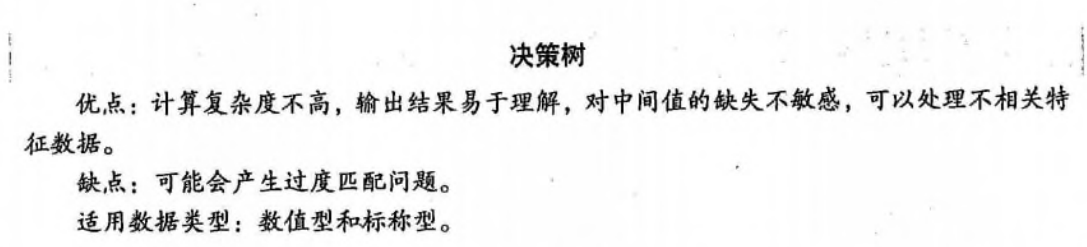

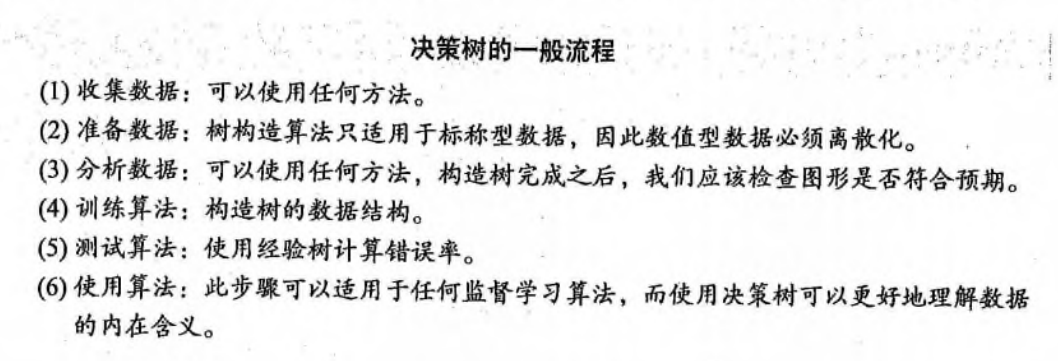

**计算香农熵公式**

$ H = - \sum_{i = 1}^n P(x_i)log_2P(x_i) $

其中，$ x_i $ 为某一分类，而 $ P(x_i) $ 是**选择该一分类的概率**

In [26]:
# 计算熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance，为所有可能的分类创建字典
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1

    # 计算熵    
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * math.log(prob,2) #log base 2
    return shannonEnt

**接下来均以该简单的分类数据集为例**：

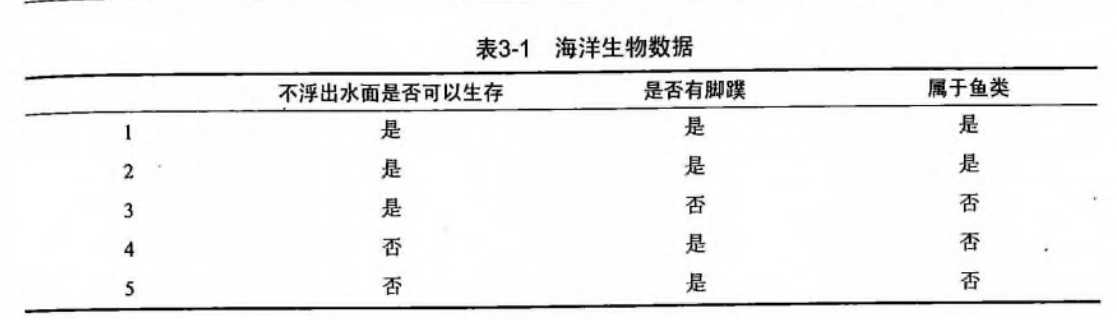

In [27]:
# 生成简单数据集
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    #change to discrete values
    return dataSet, labels

In [29]:
# 计算一下该简单数据集的熵
test_datas,test_labels = createDataSet()
print(test_datas)
print(test_labels)
calcShannonEnt(test_datas) 

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
['no surfacing', 'flippers']


0.9709505944546686

**熵越高，则混合的数据就越多，我们可以在数据集中添加更多的分类，观察熵是如何变化的**

In [30]:
test_datas[0][-1] = "Maybe"
calcShannonEnt(test_datas)

# 发现熵变大了

1.3709505944546687

**下面学习数据集的划分**

In [31]:
# 划分数据集
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting，选出符合特征的数据，去掉该特征存进新的列表里
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

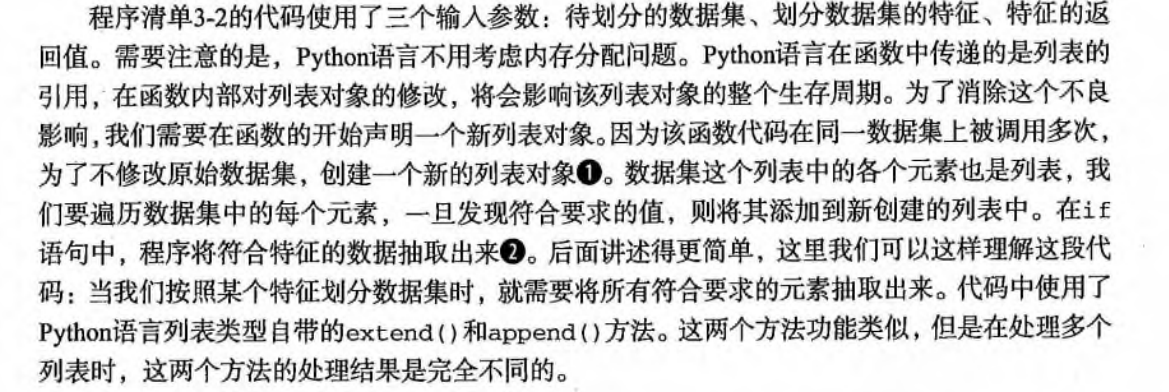

In [32]:
x = [1,2,3,4,5,6,7,8]
b = x[0:4]
b.extend(x[5:])
print(b)

[1, 2, 3, 4, 6, 7, 8]


In [33]:
# 测试
test_datas,test_labels = createDataSet()
print(test_datas)
split_data = splitDataSet(test_datas,0,1)
print(split_data)

# 发现仅有第0个特征是1的被提取

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
[[1, 'yes'], [1, 'yes'], [0, 'no']]


**接下来我们将遍历整个数据集，循环计算香农熵和splitDataSet()函数，找到最好的特征划分方式。**  
**熵计算会告诉我们如何划分数据集是最好的数据组织方式。**

In [34]:
# 选择最好的数据划分方式
def chooseBestFeatureToSplit(dataSet):

    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels，获取有多少个特征（实际上最后一个元素是类别标签）
    baseEntropy = calcShannonEnt(dataSet) # 初始熵
    bestInfoGain = 0.0; bestFeature = -1

    for i in range(numFeatures):        #iterate over all the features，遍历所有特征（最后元素不包含）
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values，构建当前特征有多少个特征值(即多少种可能值)

        newEntropy = 0.0 # 初始化新的熵
        # 计算当前特征不同特征值划分的熵，并累加为此特征划分的熵
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet) # 累加
         
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy，计算最好的信息增益，即让熵减少最大
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature                      #returns an integer

**使用上述函数的要求**

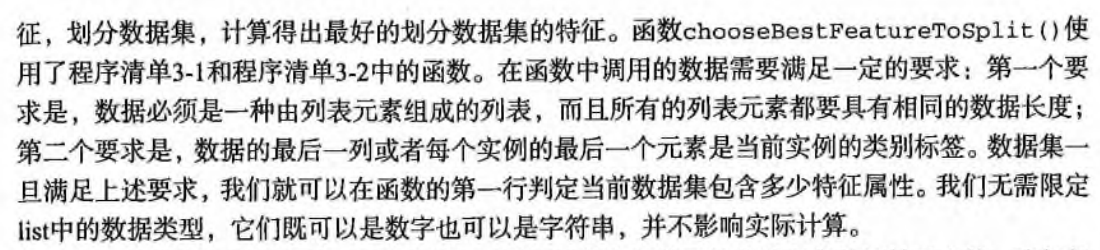

In [35]:
chooseBestFeatureToSplit(test_datas)
# 告诉我们按特征0分类最好

0

**下面我们开始学习递归构建决策树**

In [36]:
# 多数表决决定类型不一致的叶子节点的分类
def majorityCnt(classList):
    """classList为输入的label列表"""
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

**递归树终止的条件：**

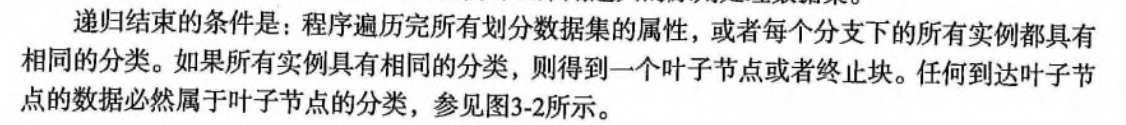

In [37]:
# 递归树的构建
def createTree(dataSet,labels):
    # 获取每个实例的所属标签
    classList = [example[-1] for example in dataSet]

    # 递归终止条件一：所有实例具有相同的label
    if classList.count(classList[0]) == len(classList): 
        return classList[0]#stop splitting when all of the classes are equal
    
    # 递归终止条件二：仅有一个特征了
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList) # 返回多数表决的结果
    
    # 继续划分数据集
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat]) # 以某个特征划分后，删除对应特征
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues) # 记录特征值的个数
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree                   

In [38]:
my_tree = createTree(test_datas,test_labels)
print(my_tree)
print(test_labels)

# 少了一个label

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
['flippers']


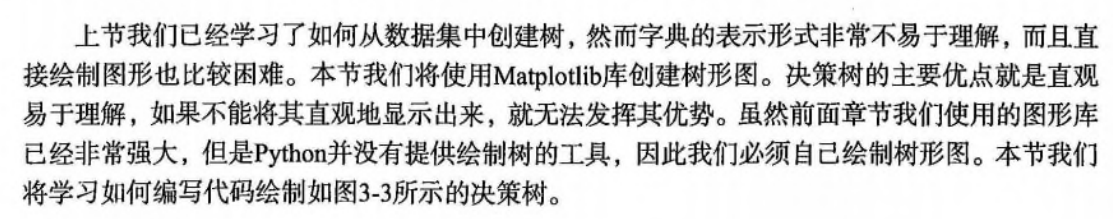

In [15]:
# 定义文本框和箭头格式
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8") 
arrow_args = dict(arrowstyle="<-") 

# 绘制带箭头的注解
def plotNode(nodeTxt, centerPt, parentPt, nodeType): 
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, 
    xycoords='axes fraction',
    xytext=centerPt, textcoords='axes fraction',
    va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

# 递归树并绘图
def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

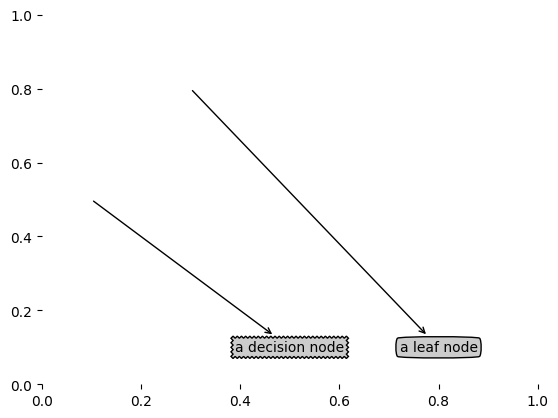

In [16]:
createPlot()

***
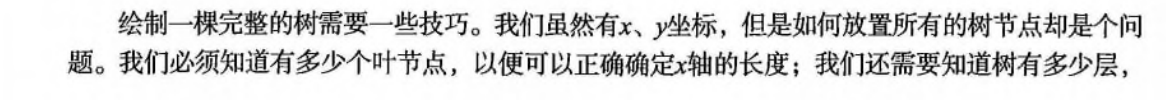

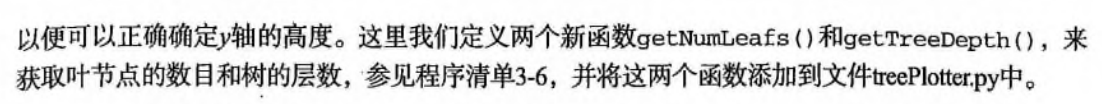

In [17]:
# 获取叶子节点的数量
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0] # 修改
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # 如果不是叶子节点（数据非字典），继续递归
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

# 获取树的最大深度
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0] # 修改
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

In [18]:
nums = getNumLeafs(my_tree)
depth = getTreeDepth(my_tree)
print(nums,depth)

3 2


In [19]:
# 在父子节点间填充文本
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

In [20]:
# 绘制递归树
def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree，获取宽度
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion，递归
        else:   #it's a leaf node print the leaf node，叶子节点
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict


In [22]:
# 最终的绘制展示
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

**绘制本节的数据集划分决策树**

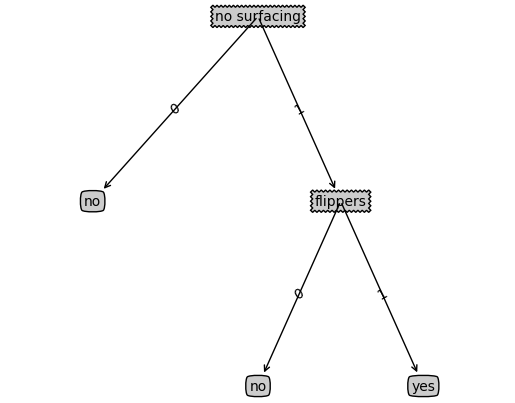

In [23]:
createPlot(my_tree)

**可以直观地看到，分类第一个特征为“no surfacing”，有0，1两个特征值**；  
**第二个分类特征为“flippers”，也有两个特征值0，1，叶子节点显示的是分类的结果，本例为二分类**